In [1]:
import kagglehub
import os

path = kagglehub.dataset_download("starktony45/image-dataset")
print("Téléchargé dans :", path)
print("Contenu :", os.listdir(path))

c:\Users\chedo\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 12.5G/12.5G [05:04<00:00, 44.1MB/s]  

Extracting files...


Téléchargé dans : C:\Users\chedo\.cache\kagglehub\datasets\starktony45\image-dataset\versions\1
Contenu : ['train2014']


In [24]:
image_obj = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            image_obj.append(os.path.join(root, file))

print(f"{len(image_obj)} images trouvées")


82783 images trouvées


In [25]:
def to_grayscale(img_rgb):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    return gray[..., None]  # (H, W, 1)

In [26]:
def gaussian_noise(img, sigma_range=(0.01, 0.08)):
    sigma = np.random.uniform(*sigma_range)
    noise = np.random.normal(0, sigma, img.shape)
    return img + noise

In [27]:
def salt_pepper_noise(img, prob_range=(0.001, 0.01)):
    p = np.random.uniform(*prob_range)
    mask = np.random.rand(*img.shape) < p
    img[mask] = np.random.choice([0.0, 1.0])
    return img

In [28]:
def multiplicative_noise(img, sigma_range=(0.02, 0.06)):
    sigma = np.random.uniform(*sigma_range)
    noise = np.random.normal(0, sigma, img.shape)
    return img * (1 + noise)

In [29]:
def correlated_noise(img, sigma=0.05):
    noise = np.random.normal(0, sigma, img.shape)
    noise = cv2.GaussianBlur(noise, (5, 5), 0)
    return img + noise

In [30]:
def structured_noise(img, max_lines=5):
    # Ensure the image is single channel for line drawing, as intended for grayscale.
    if img.ndim == 3 and img.shape[2] > 1:
        # Convert to grayscale by taking the mean along the channel axis
        # This handles cases where img might have unexpectedly become multi-channel
        img = img.mean(axis=-1, keepdims=True)
    elif img.ndim == 2: # If it's a 2D grayscale image, add a channel dimension
        img = img[..., None]

    h, w, _ = img.shape # Now img should definitely be (H, W, 1)

    for _ in range(np.random.randint(1, max_lines)):
        x = np.random.randint(0, w)
        thickness = np.random.randint(1, 5)
        cv2.line(img, (x, 0), (x, h),
                 color=np.random.uniform(0.1, 0.4), # Scalar color for 1-channel image
                 thickness=thickness)

    return img

In [31]:
def random_blur(img):
    if np.random.rand() < 0.5:
        k = np.random.choice([3, 5, 7])
        img = cv2.GaussianBlur(img, (k, k), 0)
    return img

In [32]:
import random

def degrade_image(img_gray):
    img = img_gray.copy()

    noise_functions = [
        (gaussian_noise, 0.5),
        (salt_pepper_noise, 0.3),
        (multiplicative_noise, 0.5),
        (correlated_noise, 0.5),
        (structured_noise, 0.2)
    ]

    random.shuffle(noise_functions)

    for noise_fn, prob in noise_functions:
        if random.random() < prob:
            img = noise_fn(img)

    img = random_blur(img)

    return np.clip(img, 0.0, 1.0)


In [33]:
def jpeg_compression(img, quality_range=(20, 90)):
    """
    Simule la compression JPEG sur une image normalisée [0,1].
    quality_range : intervalle de qualité JPEG (plus bas = plus dégradé)
    """
    import cv2
    import numpy as np

    # convertir en uint8
    img_uint8 = (img * 255).astype(np.uint8)

    # tirer la qualité aléatoire
    quality = np.random.randint(*quality_range)

    # encoder en JPEG en mémoire
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    result, encimg = cv2.imencode('.jpg', img_uint8, encode_param)

    # décoder pour récupérer l'image
    img_jpeg = cv2.imdecode(encimg, cv2.IMREAD_UNCHANGED)

    # remettre dans [0,1] float32
    img_jpeg = img_jpeg.astype(np.float32) / 255.0

    # si l'image était grayscale avec 1 canal, on garde le canal
    if img_jpeg.ndim == 2:
        img_jpeg = img_jpeg[..., None]

    return img_jpeg


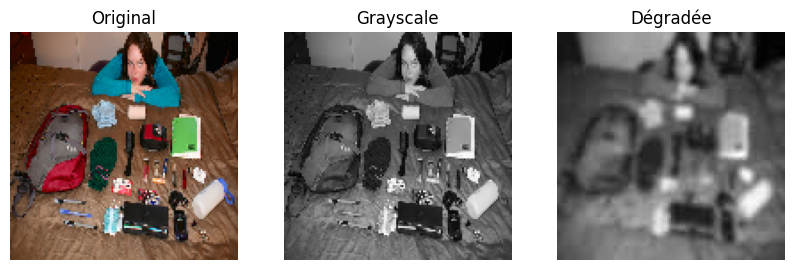

In [37]:
import matplotlib.pyplot as plt
import numpy as np # Added for np.float32 and general numpy operations
import random # Added for random.choice and random.random
import cv2
import matplotlib.pyplot as plt
import os

import random

#tester image de la deuxieme list / deuxieme dataset
img_path = random.choice(image_obj)


#tester image de la deuxieme list / deuxieme dataset

#img_name = random.choice(image_ids)
#img_path = os.path.join(img_root, img_name)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (128, 128))
img = img.astype(np.float32) / 255.0

gray = to_grayscale(img)
degraded = degrade_image(gray)

# Fix: If degraded has an unexpected number of channels (like 128),
# take the mean across the channel dimension to make it 2D for grayscale display.
# Otherwise, just squeeze it as intended.
if degraded.ndim == 3 and degraded.shape[2] > 4: # Check for unexpected multi-channel output
    degraded_for_display = degraded.mean(axis=-1)
else:
    degraded_for_display = degraded.squeeze()
jpeg_compressiong = jpeg_compression(degraded_for_display)

#on save l'iamge dégradée
cv2.imwrite("../data/degraded_image.jpg", (jpeg_compressiong * 255).astype(np.uint8))


plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.title("Original"); plt.imshow(img); plt.axis("off")
plt.subplot(1,3,2); plt.title("Grayscale"); plt.imshow(gray.squeeze(), cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title("Dégradée"); plt.imshow(jpeg_compressiong, cmap="gray"); plt.axis("off")
plt.show()

In [40]:
for i in range(1, 1000):
    

    img_path = random.choice(image_obj)

  
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    img = img.astype(np.float32) / 255.0

    gray = to_grayscale(img)
    degraded = degrade_image(gray)

    # Fix: If degraded has an unexpected number of channels (like 128),
    # take the mean across the channel dimension to make it 2D for grayscale display.
    # Otherwise, just squeeze it as intended.
    if degraded.ndim == 3 and degraded.shape[2] > 4: # Check for unexpected multi-channel output
        degraded_for_display = degraded.mean(axis=-1)
    else:
        degraded_for_display = degraded.squeeze()
    jpeg_compressiong = jpeg_compression(degraded_for_display)

    img_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f"../data/images/image_{i:05d}.jpg", (img_BGR * 255).astype(np.uint8))

    cv2.imwrite(f"../data/degraded_images/degraded_image_{i:05d}.jpg", (jpeg_compressiong * 255).astype(np.uint8))

    print(f"Image {i} saved.")


Image 1 saved.
Image 2 saved.
Image 3 saved.
Image 4 saved.
Image 5 saved.
Image 6 saved.
Image 7 saved.
Image 8 saved.
Image 9 saved.
Image 10 saved.
Image 11 saved.
Image 12 saved.
Image 13 saved.
Image 14 saved.
Image 15 saved.
Image 16 saved.
Image 17 saved.
Image 18 saved.
Image 19 saved.
Image 20 saved.
Image 21 saved.
Image 22 saved.
Image 23 saved.
Image 24 saved.
Image 25 saved.
Image 26 saved.
Image 27 saved.
Image 28 saved.
Image 29 saved.
Image 30 saved.
Image 31 saved.
Image 32 saved.
Image 33 saved.
Image 34 saved.
Image 35 saved.
Image 36 saved.
Image 37 saved.
Image 38 saved.
Image 39 saved.
Image 40 saved.
Image 41 saved.
Image 42 saved.
Image 43 saved.
Image 44 saved.
Image 45 saved.
Image 46 saved.
Image 47 saved.
Image 48 saved.
Image 49 saved.
Image 50 saved.
Image 51 saved.
Image 52 saved.
Image 53 saved.
Image 54 saved.
Image 55 saved.
Image 56 saved.
Image 57 saved.
Image 58 saved.
Image 59 saved.
Image 60 saved.
Image 61 saved.
Image 62 saved.
Image 63 saved.
I